In [7]:
import time
from itertools import chain

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import matplotlib.pyplot as plt
import numpy as np

from qutip import mesolve

from modules.atom_config import RbAtom
from modules.cavity import plotter_cavemission, cav_collapse_ops, quant_axis_cavbasis_mapping, cav_basis_trans
from modules.ketbra_config import RbKetBras

In [8]:
#List the groundstates to be included in the simulation

atomStates = {
    "g1M":0, "g1":1, "g1P":2, # F=1,mF=-1,0,+1 respectively
    "g2MM":3, "g2M":4, "g2":5, "g2P":6, "g2PP":7 # F=2,mF=-2,..,+2 respectively
}

# List the excited levels to include in the simulation. the _d1 levels correspond to the D1 line levels, the other levels are by default the d2 levels
xlvls = [
'x0',
'x1M','x1','x1P',
'x2MM','x2M','x2','x2P','x2PP',
'x3MMM', 'x3MM','x3M','x3','x3P','x3PP', 'x3PPP',
'x1M_d1','x1_d1','x1P_d1',
'x2MM_d1','x2M_d1','x2_d1','x2P_d1','x2PP_d1'
]

#configure the atm state dictionary such that it includes the desired excited states, this includes the desired ground and excited states as arguments, 
# as well as a boolean for whether to include the photonic Hilbert space

kb_class=RbKetBras(atomStates, xlvls, True)

#precompute ketbras for speed
ketbras=kb_class.getrb_ketbras()


In [9]:
#specify system b field groundstate splitting in MHz
bfieldsplit = "0"
#configure rb atom with desired CG coefficients and splittings
rb_atom = RbAtom(bfieldsplit, kb_class)

In [10]:
%%capture
#configure energy splittings from external CSV file and rb_atom_config class
[deltaZ,deltaEx3,deltaEx1,deltaEx0,\
        deltaZx3MMM,\
        deltaZx3MM,deltaZx2MM,\
        deltaZx3M,deltaZx2M,deltaZx1M,\
        deltaZx3,deltaZx2,deltaZx1,deltaZx0,\
        deltaZx3P,deltaZx2P,deltaZx1P,\
        deltaZx3PP,deltaZx2PP,\
        deltaZx3PPP ,
        deltaZ_d1,deltaEx1_d1,\
        deltaZx2MM_d1,\
        deltaZx2M_d1,deltaZx1M_d1,\
        deltaZx2_d1,deltaZx1_d1,\
        deltaZx2P_d1,deltaZx1P_d1,\
        deltaZx2PP_d1]=rb_atom.getrb_splittings_couplings()[0]

#configure Clebsch Gordan coefficients from external CSV file and atom_state_config class 
[CGg1Mx3MM, CGg1Mx2MM, \
        CGg1x3M, CGg1x2M, CGg1x1M, CGg1Mx3M, CGg1Mx2M, CGg1Mx1M, \
        CGg1Px3, CGg1Px2, CGg1Px1, CGg1Px0, CGg1x3, CGg1x2, CGg1x1, CGg1x0, CGg1Mx3, CGg1Mx2, CGg1Mx1, CGg1Mx0, \
        CGg1Px3P, CGg1Px2P, CGg1Px1P, CGg1x3P, CGg1x2P, CGg1x1P, \
        CGg1Px3PP,CGg1Px2PP,
        CGg2MMx3MMM, \
        CGg2Mx3MM, CGg2Mx2MM, CGg2MMx3MM, CGg2MMx2MM, \
        CGg2x3M, CGg2x2M, CGg2x1M, CGg2Mx3M, CGg2Mx2M, CGg2Mx1M, CGg2MMx3M, CGg2MMx2M, CGg2MMx1M, \
        CGg2Px3, CGg2Px2, CGg2Px1, CGg2Px0, CGg2x3,  CGg2x2, CGg2x1, CGg2x0, CGg2Mx3, CGg2Mx2, CGg2Mx1, CGg2Mx0, \
        CGg2PPx3P, CGg2PPx2P, CGg2PPx1P, CGg2Px3P, CGg2Px2P,  CGg2Px1P, CGg2x3P, CGg2x2P, CGg2x1P, \
        CGg2PPx3PP, CGg2PPx2PP, CGg2Px3PP, CGg2Px2PP, \
        CGg2PPx3PPP,
        CG_d1g1Mx2MM, \
        CG_d1g1x2M, CG_d1g1x1M, CG_d1g1Mx2M, CG_d1g1Mx1M, \
        CG_d1g1Px2, CG_d1g1Px1, CG_d1g1x2, CG_d1g1x1,  CG_d1g1Mx2, CG_d1g1Mx1, \
        CG_d1g1Px2P, CG_d1g1Px1P, CG_d1g1x2P, CG_d1g1x1P, \
        CG_d1g1Px2PP,
        CG_d1g2Mx2MM, CG_d1g2MMx2MM, \
        CG_d1g2x2M, CG_d1g2x1M,CG_d1g2Mx2M, CG_d1g2Mx1M, CG_d1g2MMx2M, CG_d1g2MMx1M, \
        CG_d1g2Px2, CG_d1g2Px1,CG_d1g2x2, CG_d1g2x1, CG_d1g2Mx2, CG_d1g2Mx1,  \
        CG_d1g2PPx2P, CG_d1g2PPx1P, CG_d1g2Px2P,  CG_d1g2Px1P, CG_d1g2x2P, CG_d1g2x1P, \
        CG_d1g2PPx2PP, CG_d1g2Px2PP] = rb_atom.getrb_splittings_couplings()[1]

# List the coupling rates of the system.
#   gamma:  Decay of the atomic amplitude listed for d1 and d2 transitions.
# d: Dipole moment of either d1 or d2 transition
[gamma_d2,gamma_d1,d_d2,d_d1] = rb_atom.getrb_rates()


In [11]:
#specify cavity parameters

#   kappa:  Decay of the electric field out of the cavity.
#   deltaP: polarisation splitting, i..e birefringence of the cavity
kappa = 2.1 * 2.*np.pi
deltaP = 0 * 2.*np.pi

#configure the atom-cavity coupling strength, for a 10 MHz coupling on your transition of choice --> coupling_factor=10*2*np.pi/cav_transition, 
#By default we are considering the D2 line for photon production with an optical cavity, but simply use a configured CG coefficient for D1 if you want to consider this instead, e.g. CG_d1g1Mx1
#pick the Clebsch Gordan coefficient of the desired cavity transition e.g. CGg1Mx1, g1M <-> ground state F=1, m_F=-1, x1 <-> excited state F'=1 m_F'=0

desired_vst_line='d2'
cav_transition=CGg1Mx1
coupling_factor = 11.1*2*np.pi / (cav_transition)


print('Atom-cavity coupling in {1} MHz split hyperfine states is: gLev={0}MHz'.format(
        np.round(cav_transition* coupling_factor / (2*np.pi),3), bfieldsplit))

if desired_vst_line=='d2':
  coop = (cav_transition * coupling_factor )**2/(2*kappa*gamma_d2)
else:
  coop = (cav_transition * coupling_factor )**2/(2*kappa*gamma_d1)

print('This corresponds to a cooperativity of C={0}, with theoretical upper bound in photon production efficiency of eta={1}'.format(coop, (2*coop)/(2*coop+1)))      

'''
DEFINE QUANTISATION AXIS (i.e. alignment of external magnetic field) and Cavity Axis as 3-d vectors to define polarisation basis supported by the cavity
'''
cav_axis= [1,0,0]
quant_axis = [0,1,0]

Atom-cavity coupling in 0 MHz split hyperfine states is: gLev=11.1MHz
This corresponds to a cooperativity of C=9.778571428571427, with theoretical upper bound in photon production efficiency of eta=0.95135510771369


In [12]:
#time scale is always in microseconds muS
#rabi frequencies are always angular frequencies: MHz *2pi
#detunings are always angular frequencies: MHz *2pi

Text(0.5, 0, 'Time/ microS')

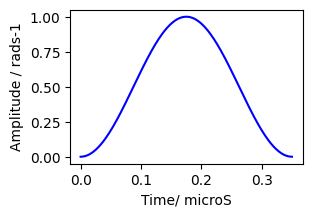

In [13]:
#Define VSTIRAP Pulse Parameters for a D2 transition and visualize the pulse
'''
Parameters:
    lengthStirap - length of the pump pulse
    vsteff_goal - desired efficiency
    delta - detuning from resonance
    OmegaStirap - Peak Rabi frequency of the pump pulse (in rad/s) which is scaled by the CG coefficient for the transition
'''
lengthStirap=0.35
OmegaStirap =230 * 2 * np.pi
delta_cav =0
delta_laser=0

tVST,tVSTStep = np.linspace(0, lengthStirap, 251, retstep=True)

# Define the VSTIRAP pulse shape
def vstomega_shape(wStirap, t):
  return (np.sin(wStirap*t)**2)

vstpulse_list = []
for x in tVST:
  vstpulse_list.append(vstomega_shape(np.pi/lengthStirap,x))

f, a1 = plt.subplots(figsize=(3, 2))
a1.plot(tVST, [ vstomega_shape(np.pi/lengthStirap,x) for x in tVST], 'b')
a1.set_ylabel('Amplitude / rads-1')
a1.set_xlabel('Time/ microS')

In [14]:
#Constructing a VSTIRAP Hamiltonian in accordance to the gen_H_VSTIRAP function specified in rb_atom_config
#Define the arguments of the driving pulse in dictionary form and the driving pulse shape in form of a string,
#                                           which can be interpreted by cython with standards numpy commands, as well as the dictionary created
#additionally one needs to define the desired F levels addressed by the VSTIRAP transitions for the initial and final ground levels F_i, F_f, as well as the excited level F'

args_omega_stirap = dict([ ('T',lengthStirap), ('wStirap',np.pi/lengthStirap)])
#vst_driving_shape='-4*np.sqrt(np.pi)*((4*(np.pi)**2 + T**2 * (g**2 + gam*kap)) * np.cos((2*np.pi*t)/T) + T*(-T* (g**2 + gam*kap) + 2* np.pi *(-gam + kap)*np.sin(  (2* np.pi*t)/T) ) )/(T* np.sqrt(8* (np.pi)**3 * (1 - 2*t*gam) + (6* np.pi * T**2 *(-g**2*(eta - 2*T*kap + 2*t*eta*kap) + eta*kap*(kap - 2*(gam + t*gam*kap))))/eta + 8*np.pi* T**2 *(g**2 + (2*gam - kap)*kap)* np.cos((2*np.pi*t)/T) -2*np.pi * (4* np.pi**2 + T**2 *(g**2 + 2*gam*kap - kap**2))* np.cos((4*np.pi*t)/T) +8*T*kap* (2* np.pi**2 + T**2 *(g**2 + gam*kap))* np.sin((2* np.pi * t)/T) - T* (-4* np.pi**2 * (gam - 2*kap) + T**2 *kap * (g**2 + gam*kap))* np.sin((4*np.pi * t)/T) ))'
vst_driving_shape='(np.sin(wStirap*t)**2)'

F_vst_start=2
F_vst_final=1
F_vst_exc= 1

[H_VStirap, args_hams_VStirap] = rb_atom.gen_H_VSTIRAP_D2(ketbras, atomStates, delta_cav,delta_laser,F_vst_start,F_vst_final,F_vst_exc,'pi', OmegaStirap, coupling_factor, deltaP, quant_axis_cavbasis_mapping(quant_axis,cav_axis),args_omega_stirap, vst_driving_shape)


<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:21: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:21: SyntaxWarning: invalid escape sequence '\O'
/var/folders/yf/cmqhy1ks3k1g6q5y0rrg_91m0000gn/T/ipykernel_96043/895295128.py:20: SyntaxWarning: invalid escape sequence '\O'
  a1.plot(tRepump, [A_s*stokes_shape_plot(x, lengthRepump) for x in tRepump], 'b',label='$\Omega_S(t)$')
/var/folders/yf/cmqhy1ks3k1g6q5y0rrg_91m0000gn/T/ipykernel_96043/895295128.py:21: SyntaxWarning: invalid escape sequence '\O'
  a1.plot(tRepump, [A_p*shape_pump_plot(x, lengthRepump) for x in tRepump], 'r',label='$\Omega_P(t)$')


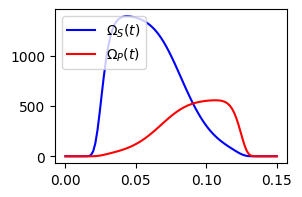

In [15]:
######For STIRAP Repreparation visualize the pulse shapes#####

#Define the repumping pulse parameters for special masked pulse shapes
#A*CG... - peak rabi frequency of the pulses
A_rep = 41
#make sure to add CG
[A_s,A_p] = [abs(x)*2*np.pi for x in [A_rep/CGg2x1,A_rep/CGg1Px1]]
lengthRepump=0.15
tRepump,tRepumpStep = np.linspace(0, lengthRepump, 100, retstep=True)

a=11
n=6
c=0.05
def stokes_shape_plot(t,T):
    return (np.exp(-((t - (T/2))/c)**(2*n))*np.cos(np.pi/2*(1/(1 + np.exp((-a*(t - T/2))/T)))))
def shape_pump_plot(t,T):
    return (np.exp(-((t - (T/2))/c)**(2*n))*np.sin(np.pi/2*(1/(1 + np.exp((-a*(t - T/2))/T)))))
                                                                                                                        
f, a1 = plt.subplots(figsize=(3, 2))
a1.plot(tRepump, [A_s*stokes_shape_plot(x, lengthRepump) for x in tRepump], 'b',label='$\Omega_S(t)$')
a1.plot(tRepump, [A_p*shape_pump_plot(x, lengthRepump) for x in tRepump], 'r',label='$\Omega_P(t)$')
a1.legend(loc=2)
f.patch.set_facecolor('white')



In [16]:
#Constructing a SITRAP repumping Hamiltonian in accordance to the gen_H_Pulse function specified in rb_atom_config
#Define the arguments of the driving pulse in dictionary form and the driving pulse shape in form of a string,
#                                           which can be interpreted by cython with standards numpy commands, as well as the dictionary created
#additionally one needs to define the desired levels addressed by the STIRAP repumping transitions

args_repump = dict([('n',n), ('c',c), ('a',a),('T', lengthRepump), ])

pump_shape='np.exp(-((t - (T/2))/c)**(2*n))*np.sin(np.pi/2*(1/(1 + np.exp((-a*(t - T/2))/T))))'
stokes_shape='np.exp(-((t - (T/2))/c)**(2*n))*np.cos(np.pi/2*(1/(1 + np.exp((-a*(t - T/2))/T))))'
delta_sti=0
F_pump_start=1
F_pump_exc=1
F_stokes_start=2
F_stokes_exc=1

stokes_pol='pi'
pump_pol_1='sigmaP'
pump_pol_2='sigmaM'

H_Stirap_Stokes=rb_atom.gen_H_Pulse_D1(ketbras, atomStates, delta_sti,F_stokes_start,F_stokes_exc,stokes_pol,A_s,args_repump,stokes_shape)
H_Stirap_Pump_1= rb_atom.gen_H_Pulse_D1(ketbras, atomStates, delta_sti,F_pump_start,F_pump_exc,pump_pol_1,A_p,args_repump,pump_shape, )
H_Stirap_Pump_2= rb_atom.gen_H_Pulse_D1(ketbras, atomStates, delta_sti,F_pump_start,F_pump_exc,pump_pol_2,A_p, args_repump,pump_shape )

H_Repump =  list(chain(*[H_Stirap_Stokes[0], H_Stirap_Pump_1[0], H_Stirap_Pump_2[0] ]))
args_hams_Repump= {**H_Stirap_Stokes[1], **H_Stirap_Pump_1[1], **H_Stirap_Pump_2[1]}


In [17]:
#Define pulse shapes for optical pumping
length_OpticalPump=3
#technically the pulse shape is a smooth ramp with a flat top (accounting for modulator rise time) to mimic a tophat, but this doesn't meaningfully alter the results
pump_shape= '1'
args_optical_pumping = dict([('T', length_OpticalPump)])

#Define the optical pumping pulse parameters
deltaPulse1= 4*2*np.pi # Repumping Pulse 1 detuning
deltaPulse2= -7.5*2*np.pi # Repumping Pulse 2 detuning

Omega1=34*2*np.pi   # Repumping Pulse 1 Rabi frequency
Omega2=24*2*np.pi   # Repumping Pulse 2 Rabi frequency

pump_1_pol='pi'
pump_2_pol='pi'

F_pump_1_start=1
F_pump_1_exc=2

F_pump_2_start=2
F_pump_2_exc=2

H_OpticalPump_1= rb_atom.gen_H_Pulse_D1(ketbras, atomStates, deltaPulse1,F_pump_1_start,F_pump_1_exc,pump_1_pol,Omega1, args_optical_pumping,pump_shape)
H_OpticalPump_2= rb_atom.gen_H_Pulse_D1(ketbras, atomStates, deltaPulse2,F_pump_2_start,F_pump_2_exc,pump_2_pol,Omega2, args_optical_pumping, pump_shape,)

H_OpticalPump=  list(chain(*[H_OpticalPump_1[0], H_OpticalPump_2[0]]))
args_hams_OpticalPump= {**H_OpticalPump_1[1], **H_OpticalPump_2[1]}

In [18]:
# A list of Hamiltonians to pre-compile in the form:
#    (Cythonised Hamiltonian, arguement dictionary, compiled file name)
H_list = [
    (H_OpticalPump, args_hams_OpticalPump, 'H_OpticalPump'),
   (H_VStirap, args_hams_VStirap, 'H_VStirap'),
    (H_Repump, args_hams_Repump, 'H_Repump')
]

#define list of collapse operators
c_op_list=[]
c_op_list+= cav_collapse_ops(kappa, atomStates)

#by default we are adding the collapse operators for both the d2 and d1 line, but comment out either if only one is desired
c_op_list += rb_atom.spont_em_ops(atomStates)[0] #d2 line
c_op_list+=rb_atom.spont_em_ops(atomStates)[1] #d1 line

In [19]:
'''
Set up simulations
'''
#define length of each Hamiltonian, it might be interesting to pick a length longer than the individual pulse duration to consider the effect of non-unitary losses
tVStirap,tVStirapStep = np.linspace(0, lengthStirap, 200, retstep=True)
tRepump,tRepumpStep = np.linspace(0, lengthRepump, 150, retstep=True)
tOpticalPump,tOpticalPumpStep = np.linspace(0, length_OpticalPump, 251, retstep=True)


psi0 = kb_class.get_ket('g2',0,0) # Initial state of the system in array format with dictionary, atomic state and cavity fock states (atomStates, 'atomic state', N_cavx, N_cavy]
n_Cycles = 1 # Number of times to apply the sequence of actions defined in H_list

# The actions to apply in terms of a list of the form
#      (Cythonised Hamiltonian,
#       list of time steps,
#       argument dictionary,
#       compiled file name)
H_list = [
  #(H_OpticalPump, tOpticalPump, args_hams_OpticalPump, 'H_OpticalPump')  
  (H_VStirap, tVStirap, args_hams_VStirap, 'H_VStirap'),
  (H_Repump, tRepump, args_hams_Repump, 'H_Repump') 
    ]

In [20]:
'''
Perform simulation
'''

#we return the density operators after each simulation run for each timestep in the simulation and save it in a list called output states list

i, n_hams = 0, len(H_list)*n_Cycles
output_states_list = []
t_list = []
for H, t, args, label in H_list*n_Cycles:

    t_start = time.time()
    
    output = mesolve(H, psi0, t, c_op_list, [], args=args)
    
    i+=1
    print('Simulation {0}/{1} with {2} timesteps completed in {3} seconds'.format(
            i, n_hams, t.size,np.round(time.time()-t_start,3) ))
    
    output_states_list.append(output.states)
    t_list.append(t)

    psi0=output.states[-1]

   

/Users/janoleernst_normal/Documents/rb_photon_prod_dev/.venv/lib/python3.13/site-packages/qutip/solver/solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/Users/janoleernst_normal/Documents/rb_photon_prod_dev/.venv/lib/python3.13/site-packages/qutip/core/coefficient.py:423: UserWarning: `cython`, `setuptools` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


Simulation 1/2 with 200 timesteps completed in 18.115 seconds
Simulation 2/2 with 150 timesteps completed in 6.757 seconds


Total cavity emission: 0.833


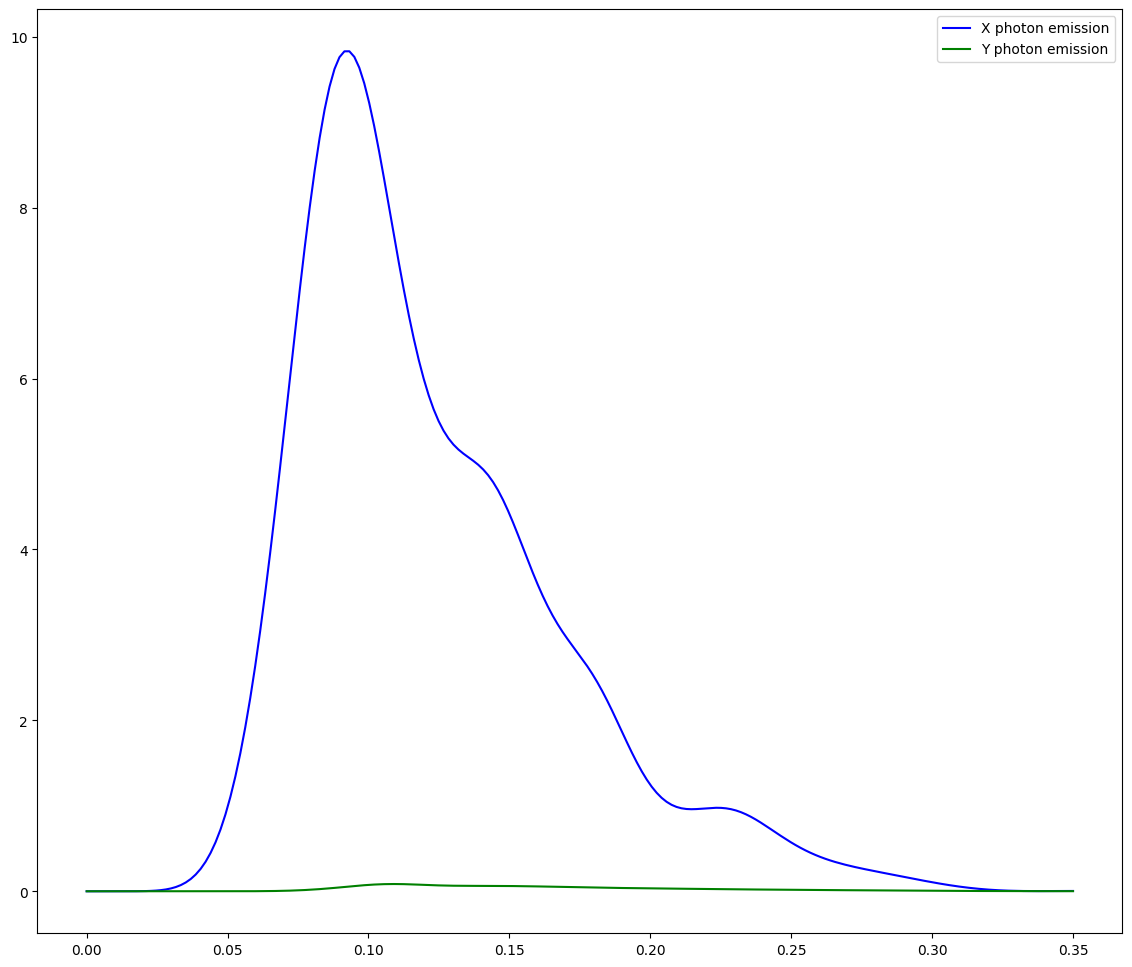

Total cavity emission in linear basis: 0.824 0.009


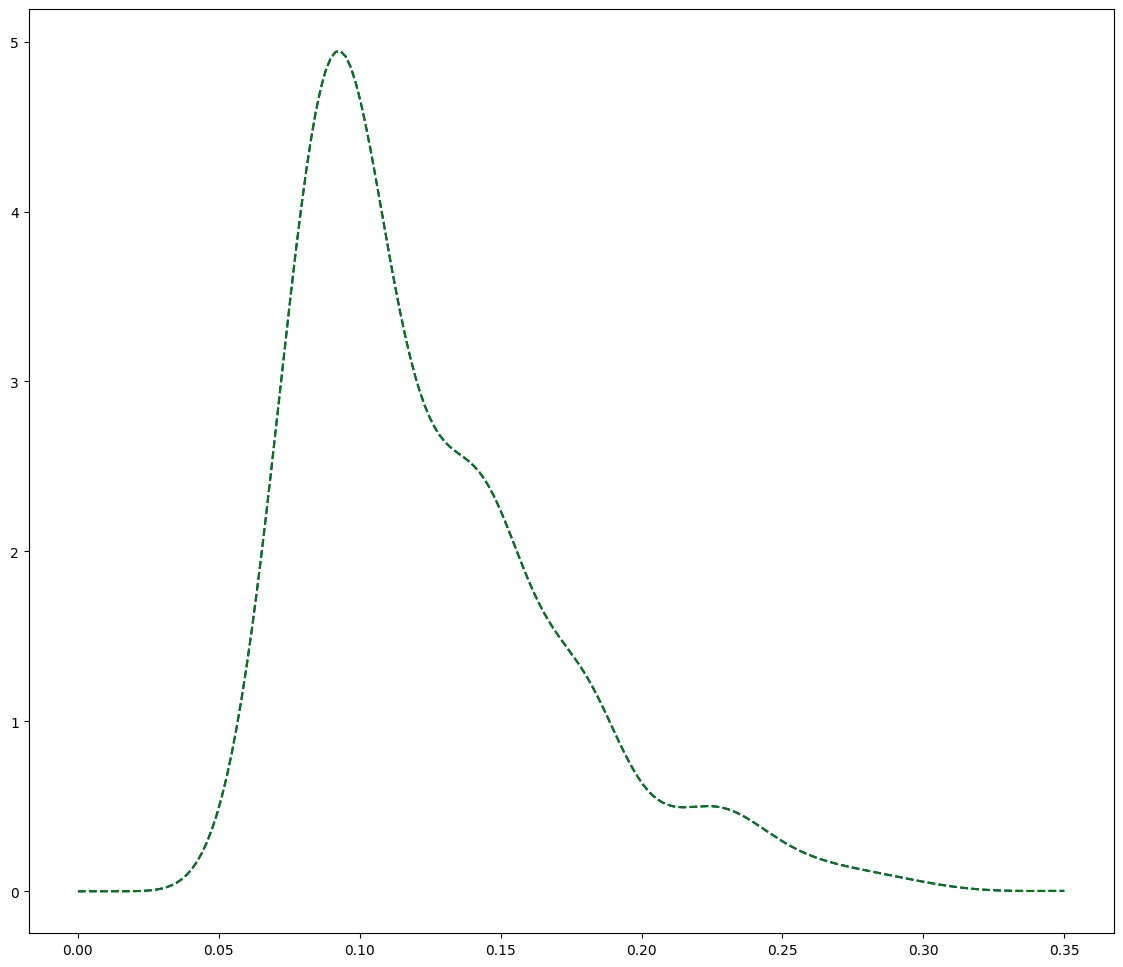

Rotated cavity basis with params: alpha = 0.7071067811865476, phi1 = 1.5707963267948966, phi2 = 0
Total cavity emission in rotated basis: 0.416 0.416
Total spontaneous emission from D1: 0.0
Total spontaneous emission from D2: 0.163


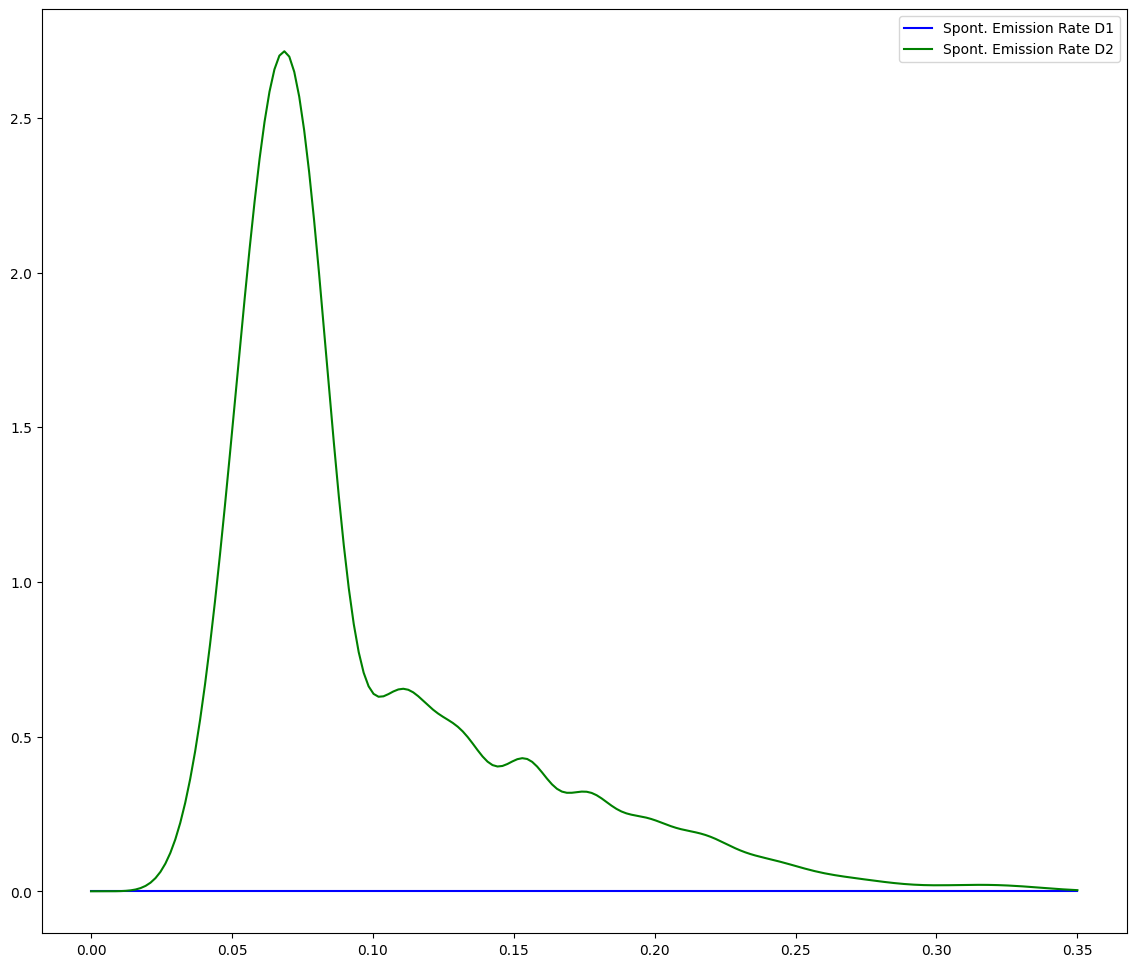

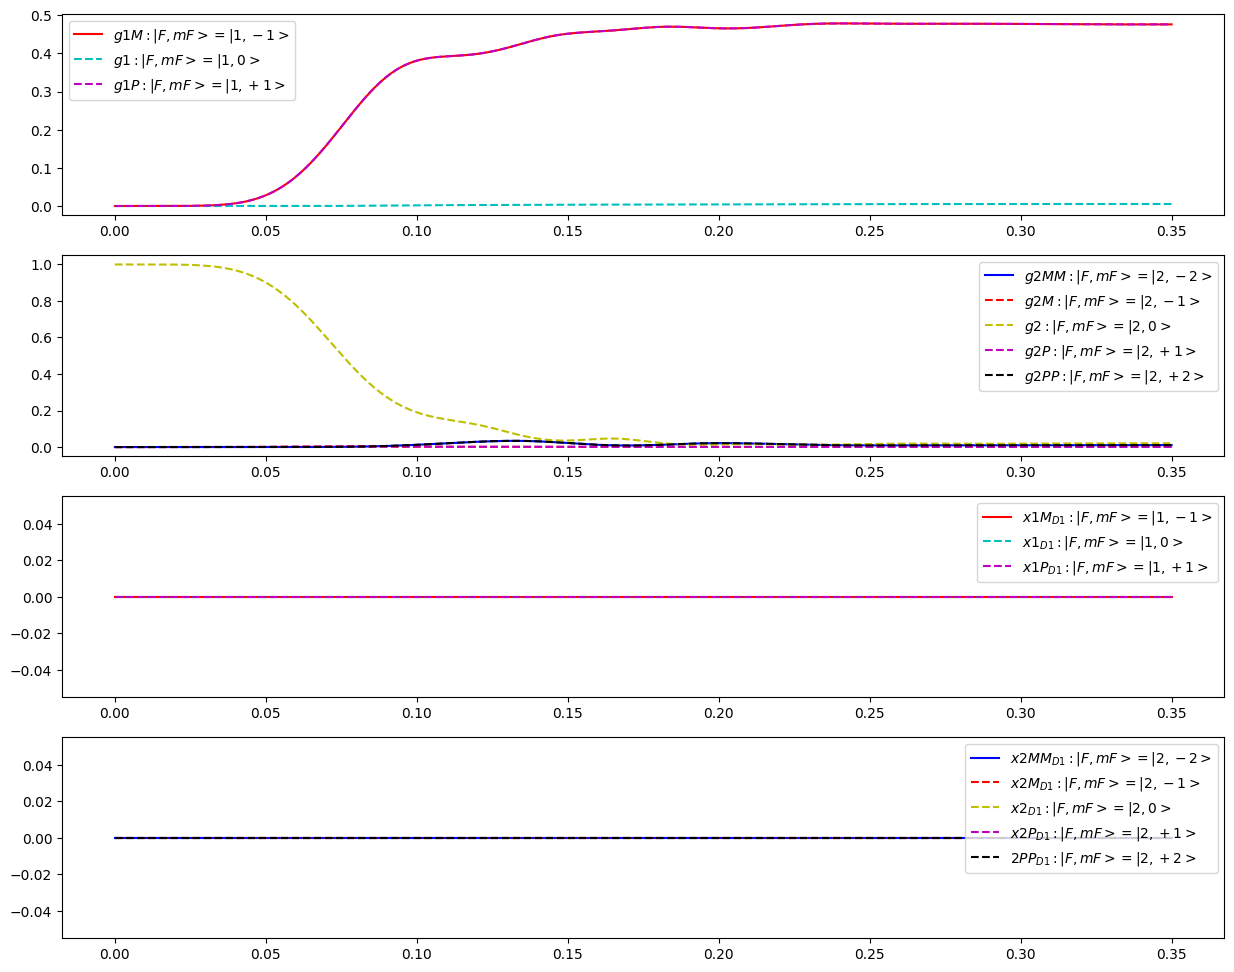

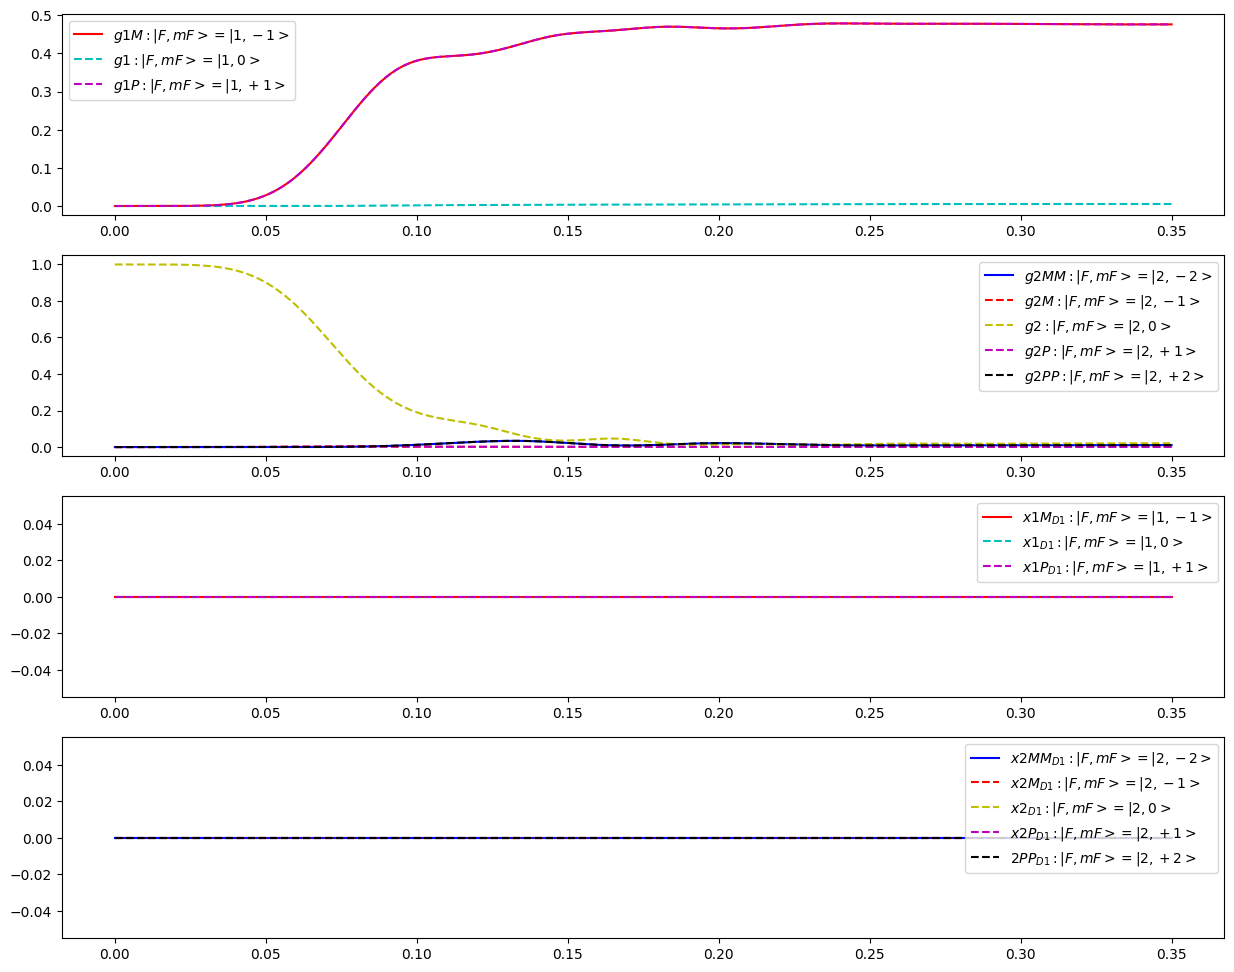

In [21]:
#pick the index of the Hamiltonian simulation you want to plot
ham_index=0
plot_output=output_states_list[ham_index]
plot_timelist=t_list[ham_index]

#plotting the results
#all plotting function require the following 4 arguments:
#ketbras: the configured ketbras of the system
#atomStates: the atomic groundstates of the system
#plot_output: the ouquantum object list outputted by the simulation
#plot_timelist: the list of timesteps for which the simulation was run
    #plotter_cavemission also requires the polarisation arguments phi1, phi2, alpha, beta for the desired additional cavity polarisation basis
    #plotter_spontdecay_channels requires no additional arguments
    #plotter_atomstate_population requires a Boolean as to whether to include the excited state population relevant for the D1 transitions
    
#define alternative cavity polarisation basis, by default this is circular:
alpha=np.sqrt(1/2)
phi1=np.pi/2
phi2=0    

plotter_cavemission(ketbras, atomStates, plot_output, plot_timelist, kappa,deltaP, True, angles_pol=cav_basis_trans(alpha, phi1, phi2))
rb_atom.plotter_spontdecay_channels(atomStates, plot_output,plot_timelist)
rb_atom.plotter_atomstate_population(ketbras, plot_output,plot_timelist, True)
